<a href="https://colab.research.google.com/github/Namneet2001/Object-Segmentation-and-Position-Shift-using-Generative-AI/blob/main/Object_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK 1**

Install Required Libraries

In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install Pillow
!pip install opencv-python


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-j_rree3z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-j_rree3z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=8fccf1c2b1da346826bcff2340914db909584eff1bdae9bbf41686763332c73e
  Stored in directory: /tmp/pip-ephem-wheel-cache-l2g27v8h/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bl23j6xn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bl23j6xn
  Resolved https://github.com/facebookresearch/segment-a

Download the SAM Model

In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


--2024-10-09 18:53:55--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   189MB/s    in 15s     

2024-10-09 18:54:10 (167 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



Upload Your Images to Colab

In [3]:
from google.colab import files
uploaded = files.upload()

Saving bagpack.jpg to bagpack (1).jpg
Saving stool.jpeg to stool (1).jpeg
Saving wall hanging.jpg to wall hanging (1).jpg


Implement the Code

Similarity score for 'wall hanging': 0.251220703125
Output saved to '/content/output_wall_hanging.jpg'.


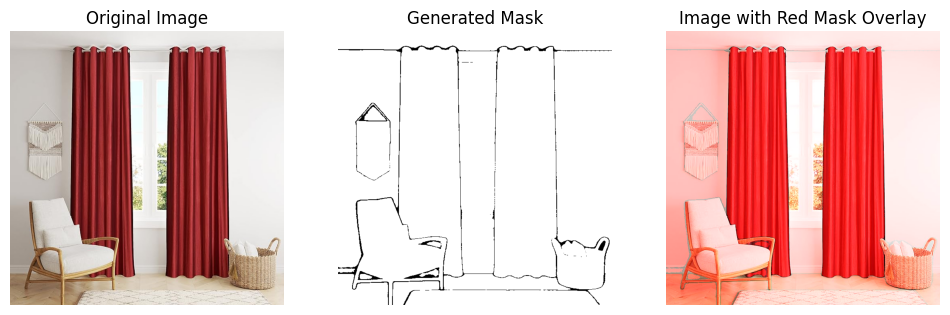

In [5]:
import torch
from PIL import Image
import clip
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def load_clip_model(device):
    """ Load the CLIP model """
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    return clip_model, preprocess

def generate_masks(sam, image_array):
    """ Generate segmentation masks using SAM """
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(image_array)
    return masks

def load_sam_model(checkpoint_path):
    """ Load the SAM model """
    sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)
    return sam

def display_images(original_image, masked_image, mask):
    """ Display the original image, the red mask, and the final output """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Generated Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(masked_image)
    plt.title("Image with Red Mask Overlay")
    plt.axis('off')

    plt.show()

def main(image_path, object_class, output_path):
    # Load CLIP model and SAM model
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    clip_model, preprocess = load_clip_model(device)
    sam = load_sam_model("/content/sam_vit_h_4b8939.pth")

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([object_class]).to(device)

    # Compute image and text features
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)

    # Calculate cosine similarity between text and image
    similarity = torch.cosine_similarity(image_features, text_features)
    print(f"Similarity score for '{object_class}': {similarity.item()}")

    # Generate segmentation masks using SAM
    image_array = np.array(image)
    masks = generate_masks(sam, image_array)

    # Initialize a blank mask
    final_mask = np.zeros(image_array.shape[:2], dtype=np.uint8)

    # Apply masks where objects are found
    for mask in masks:
        final_mask[mask['segmentation']] = 255

    # Create a red mask on the original image
    red_mask = np.zeros_like(image_array)
    red_mask[final_mask == 255] = [255, 0, 0]  # Red color

    # Overlay the mask on the original image
    overlay_image = cv2.addWeighted(image_array, 1, red_mask, 0.5, 0)

    # Save the output image
    output_image = Image.fromarray(overlay_image)
    output_image.save(output_path)
    print(f"Output saved to '{output_path}'.")

    # Display the images
    display_images(image_array, overlay_image, final_mask)

# Run the main function for 'wall hanging'
main('/content/wall hanging.jpg', 'wall hanging', '/content/output_wall_hanging.jpg')
